# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-07-26.ipynb)

## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 26. unCLIP

OpenAI の DALL-E 2 のベースとなっている unCLIP [[Ramesh+ CoRR'22]](https://arxiv.org/abs/2204.06125) を再現したもモデルや Stable Diffusion を fine-tuning した Stable unCLIP を用いて、画像生成を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Sat Jul 22 09:56:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00


## unCLIP を扱うパイプラインを構築

DALL-E 2 を始め、unCLIP 自体の事前学習済みモデルは現状公開されておりません。

代わりに有志が unCLIP をベースに学習済みモデルを構築し、`UnCLIPPipeline` や `StableUnCLIPPipeline` で簡単に使用できるように整備しています。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

今回は unCLIP の論文で DALL-E 2 の生成画像の例としてあげられている以下の `vibrant portrait painting of Salvador Dalí with a robotic half face` というプロンプトから生成された画像と、unCLIP および Stable unCLIP による生成画像を比較していきます。

Prompt: vibrant portrait painting of Salvador Dalí with a robotic half face
Original image size: (1024, 1024)


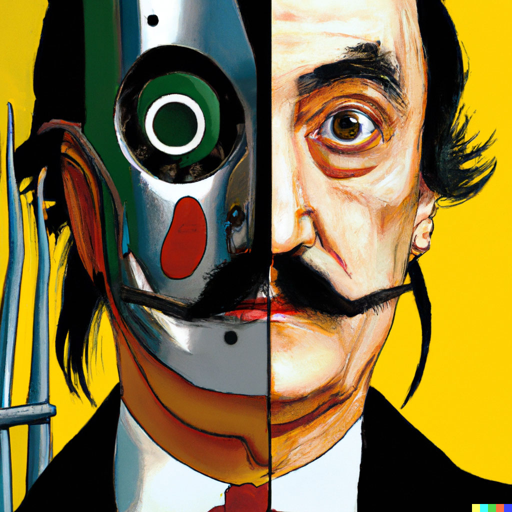

In [ ]:
from diffusers.utils import load_image

prompt = "vibrant portrait painting of Salvador Dalí with a robotic half face"

image_dalle2 = load_image("https://ar5iv.labs.arxiv.org/html/2204.06125/assets/figures/banner_samples/Vibrant_portrait_painting_of_salvador_dali_with_a_robotic_half_face.jpg")

print(f"Prompt: {prompt}")
print(f"Original image size: {image_dalle2.size}")
image_dalle2 = image_dalle2.resize((512, 512))
image_dalle2

### UnCLIPPipeline による画像生成

前述の通り、DALL-E 2 自体の学習済みの重みは公開されていません。

かわりに、unCLIP をベースとした [Karlo](https://huggingface.co/kakaobrain/karlo-v1-alpha) というモデルが [kakaobrain](https://kakaobrain.com/) という企業から公開されています。本セクションでは kakaobrain が公開している [`kakaobrain/karlo-v1-alpha`](https://huggingface.co/kakaobrain/karlo-v1-alpha) を使用して [`UnCLIPPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/unclip) によるパイプラインの動作を確認します。

In [ ]:
import torch
from diffusers import UnCLIPPipeline

model_id = "kakaobrain/karlo-v1-alpha"
data_type = torch.float16

pipe = UnCLIPPipeline.from_pretrained(
    model_id, torch_dtype=data_type,
)
pipe = pipe.to("cuda")

Fetching 20 files:   0%|          | 0/20 [00:00<?, ?it/s]

`UnCLIPPiepline` を用いて画像を生成します。unCLIP は prior と decoder の 2 つのモジュールの組み合わせからなるモデルでした。ここでは `prior_num_inference_steps` と `decoder_num_inference_steps` を指定して、それぞれのモジュールにおける diffusion step 数を指定可能です。更には `super_res_num_inference_steps` によって超解像用のモジュールにおける diffusion step も指定可能です。

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Prompt: vibrant portrait painting of Salvador Dalí with a robotic half face
Original image size: (256, 256)


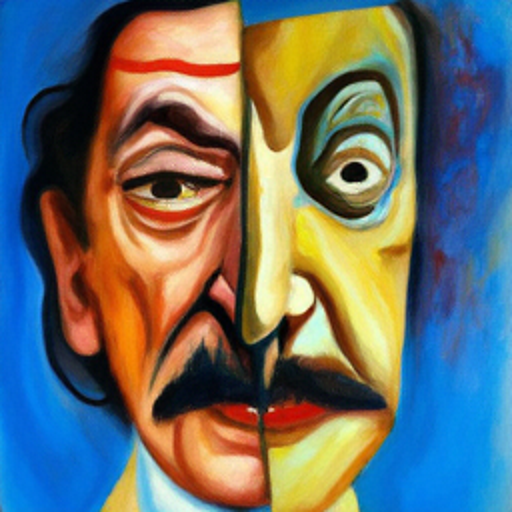

In [ ]:
generator = torch.Generator().manual_seed(19950815)

image_kalro = pipe(
    prompt,
    prior_num_inference_steps=25,
    decoder_num_inference_steps=25,
    super_res_num_inference_steps=7,
    generator=generator,
).images[0]

print(f"Prompt: {prompt}")
print(f"Original image size: {image_kalro.size}")
image_kalro = image_kalro.resize((512, 512))
image_kalro

### StableUnCLIPPipeline による画像生成

StableDiffusion の学習済みパラメータを unCLIP へ転用する試みがあります。

Stable unCLIP は Stable Diffusion v2.1 を fine-tuning したもので、CLIP による画像・テキスト両者で条件付けが可能になっています。本セクションでは [stabilityai/stable-diffusion-2-1-unclip-small](https://hf.co/stabilityai/stable-diffusion-2-1-unclip-small) を使用して [`StableUnCLIPPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/stable_unclip) によるパイプラインの動作を確認します。

Stable unCLIP は推論時に画像埋め込みベクトルにどの程度ノイズを加えるかを決定する `noise_level` を設定可能です。この `noise_level` が高いほど、最終的な生成画像の多様性が高まります。デフォルトではノイズを追加しない `noise_level = 0` が設定されています。

Stable unCLIP は上述の KakaoBrain の Karlo をベースに利用しています。以下のようにして prior となるモデル群を読み込んでいきます。

In [ ]:
from diffusers import UnCLIPScheduler, DDPMScheduler, StableUnCLIPPipeline
from diffusers.models import PriorTransformer
from transformers import CLIPTokenizer, CLIPTextModelWithProjection

prior_model_id = "kakaobrain/karlo-v1-alpha"
prior = PriorTransformer.from_pretrained(prior_model_id, subfolder="prior", torch_dtype=data_type)

prior_text_model_id = "openai/clip-vit-large-patch14"
prior_tokenizer = CLIPTokenizer.from_pretrained(prior_text_model_id)
prior_text_model = CLIPTextModelWithProjection.from_pretrained(prior_text_model_id, torch_dtype=data_type)
prior_scheduler = UnCLIPScheduler.from_pretrained(prior_model_id, subfolder="prior_scheduler")
prior_scheduler = DDPMScheduler.from_config(prior_scheduler.config)

Karlo では prior として OpenAI の `CLIP ViT-L/14` が使用されていますが、Stable unCLIP の学習済みモデル `stabilityai/stable-diffusion-2-1-unclip-small` でも同様に使用しています。似た学習済みモデルとして [`stabilityai/stable-diffusion-2-1-unclip`](https://hf.co/stabilityai/stable-diffusion-2-1-unclip) がありますが、こちらは `OpenCLIP ViT-H` で学習されているため、今回 Karlo に合わせて前者の学習済みモデルを使用しています。

In [ ]:
stable_unclip_model_id = "stabilityai/stable-diffusion-2-1-unclip-small"

pipe = StableUnCLIPPipeline.from_pretrained(
    stable_unclip_model_id,
    torch_dtype=data_type,
    variant="fp16",
    prior_tokenizer=prior_tokenizer,
    prior_text_encoder=prior_text_model,
    prior=prior,
    prior_scheduler=prior_scheduler,
)
pipe = pipe.to("cuda")

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

`StableDiffusionUnCLIPPipeline` を用いて画像を生成します。このパイプラインでは 2023/07/20 現在、prior に対する指定のみが存在しています（[参考](https://huggingface.co/docs/diffusers/v0.16.0/en/api/pipelines/stable_unclip#diffusers.StableUnCLIPPipeline.__call__)）。今回は以下のようにして `prior_num_inference_steps` を設定して画像を生成させてみます。

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Prompt: vibrant portrait painting of Salvador Dalí with a robotic half face
Original image size: (768, 768)


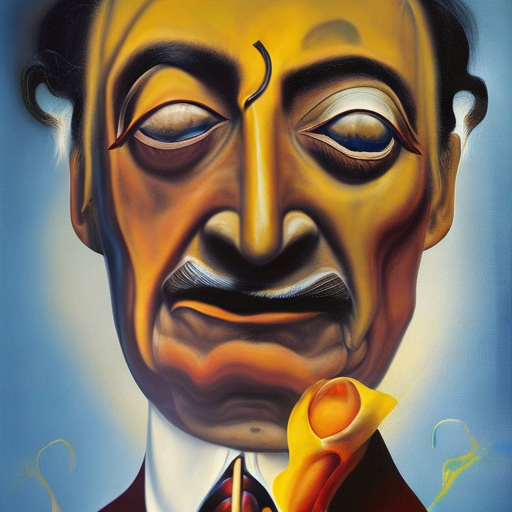

In [ ]:
generator = torch.Generator().manual_seed(19950815)

image_sd_unclip = pipe(
    prompt,
    prior_num_inference_steps=25,
    generator=generator,
).images[0]

print(f"Prompt: {prompt}")
print(f"Original image size: {image_sd_unclip.size}")
image_sd_unclip = image_sd_unclip.resize((512, 512))
image_sd_unclip

では、DALL-E 2 による生成画像と、これまで unCLIP Karlo と Stable unCLIP で生成した画像を比較してみます。

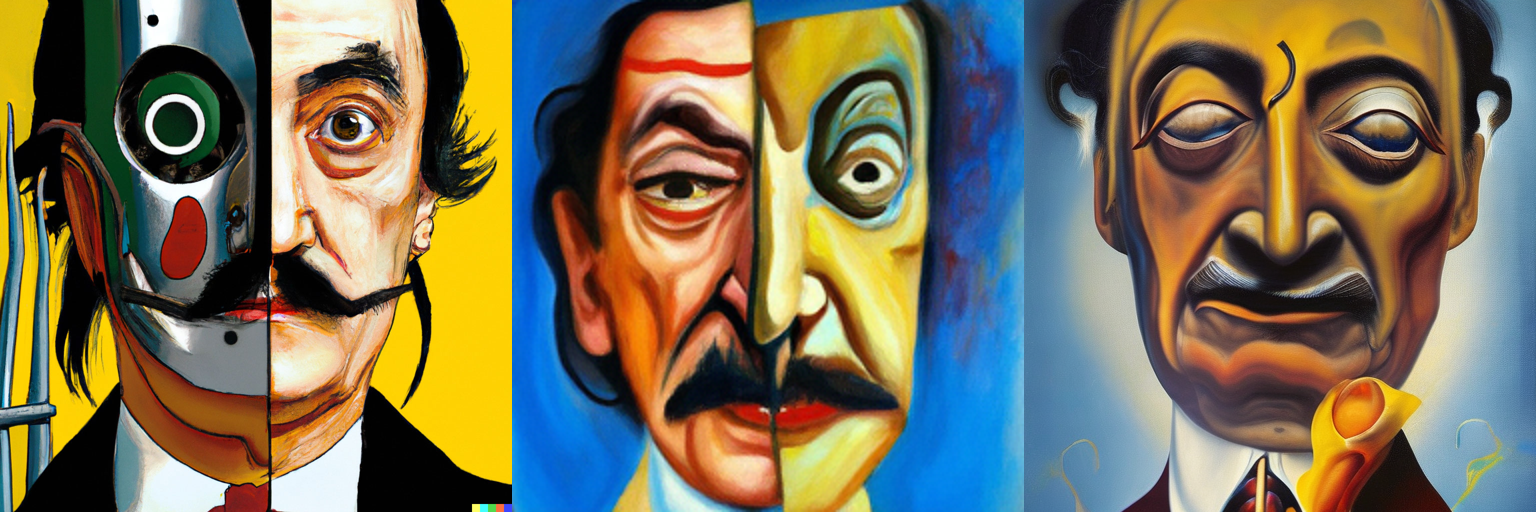

In [ ]:
image_grid([image_dalle2, image_kalro, image_sd_unclip], rows=1, cols=3)

それぞれ違った良さがありそうです。解像度の観点だと、DALL-E 2 は 1024 x 1024、Karlo は 256 x 256、Stable unCLIP は 768 x 768 でした。DALL-E 2 以外はモデルの重みが公開されているので、研究的な意味でも扱いやすくなっています。